In [150]:
# Import relevant libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


%matplotlib inline

In [151]:
# Load dataset

df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv")
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [152]:
# Dataset information

print(f"Dataset Shape: \n {df.shape[0]} rows and {df.shape[1]} columns \n")

print("Dataframe Information: \n")
df.info()

Dataset Shape: 
 1462 rows and 9 columns 

Dataframe Information: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [153]:
# Target Variable inspection

col = 'converted'

counts = df[col].value_counts()
percents = df[col].value_counts(normalize=True).mul(100).round(2)

value_counts_summary = pd.DataFrame({'Count': counts, 'Percent': percents})
print(f"\nColumn: {col}")
print(value_counts_summary)


Column: converted
           Count  Percent
converted                
1            905     61.9
0            557     38.1


In [154]:
# Descriptive Statistics

df.describe()

,number_of_courses_viewed,annual_income,interaction_count,lead_score,converted
count,1462.000000,1281.000000,1462.000000,1462.000000,1462.000000
mean,2.031464,59886.273224,2.976744,0.506108,0.619015
std,1.449717,15070.140389,1.681564,0.288465,0.485795
min,0.000000,13929.000000,0.000000,0.000000,0.000000
25%,1.000000,49698.000000,2.000000,0.262500,0.000000
50%,2.000000,60148.000000,3.000000,0.510000,1.000000
75%,3.000000,69639.000000,4.000000,0.750000,1.000000
max,9.000000,109899.000000,11.000000,1.000000,1.000000


In [155]:
# Check for missing values

print("\nMissing values per column:\n")
print(df.isnull().sum())


Missing values per column:

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64


In [156]:
# Replace missing values - For categorical features:'NA'
categorical_cols = df.select_dtypes(include='object').columns
df[categorical_cols] = df[categorical_cols].fillna('NA')

In [157]:
# Replace missing values - For numeric features :0.0

numeric_cols = [col for col in df.columns if col not in categorical_cols]
df[numeric_cols] = df[numeric_cols].fillna(0.0)

In [158]:
# Check if there are any missing values remaining
print("\nMissing values per column after imputation:\n")
print(df.isnull().sum())


Missing values per column after imputation:

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64


In [159]:
# Question 1: Find the most frequent observation (mode) for the 'industry' column

industry_mode = df['industry'].mode()[0]
print("Most frequent industry:", industry_mode)

Most frequent industry: retail


In [160]:
# Question 2: Create the correlation matrix for the numerical features of your dataset

corr_matrix = df[numeric_cols].corr()
corr_matrix

,number_of_courses_viewed,annual_income,interaction_count,lead_score,converted
number_of_courses_viewed,1.000000,0.009770,-0.023565,-0.004879,0.435914
annual_income,0.009770,1.000000,0.027036,0.015610,0.053131
interaction_count,-0.023565,0.027036,1.000000,0.009888,0.374573
lead_score,-0.004879,0.015610,0.009888,1.000000,0.193673
converted,0.435914,0.053131,0.374573,0.193673,1.000000


In [161]:
# Display the correlation values for the specified pairs
pairs = [
    ('interaction_count', 'lead_score'),
    ('number_of_courses_viewed', 'lead_score'),
    ('number_of_courses_viewed', 'interaction_count'),
    ('annual_income', 'interaction_count')
]

for a, b in pairs:
    corr_value = corr_matrix.loc[a, b]
    print(f"Correlation between {a} and {b}: {corr_value:.6f}")

Correlation between interaction_count and lead_score: 0.009888
Correlation between number_of_courses_viewed and lead_score: -0.004879
Correlation between number_of_courses_viewed and interaction_count: -0.023565
Correlation between annual_income and interaction_count: 0.027036


The correlation between annual_income and interaction_count is the highest.

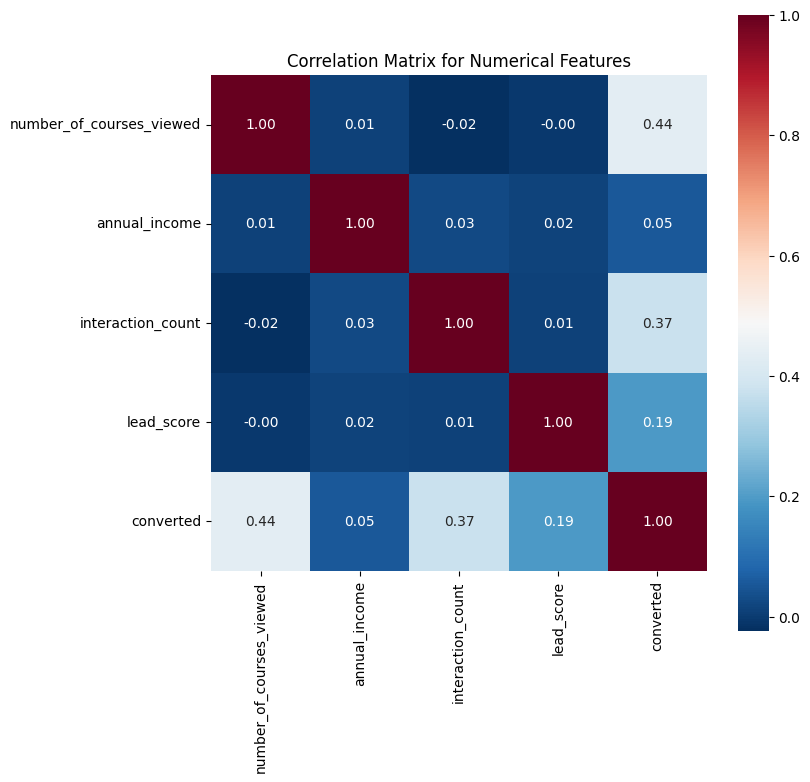

In [162]:
# # Create interactive Plotly heatmap
# fig = px.imshow(
#     corr_matrix,
#     text_auto=".3f",
#     color_continuous_scale='RdBu_r',
#     title="Correlation Matrix for Numerical Features",
#     aspect="equal", 
# )

# fig.update_layout(
#     title_x=0.5,
#     title_font=dict(size=20),
#     xaxis_title="Features",
#     yaxis_title="Features",
#     width=1000, 
#     height=800
# )
# fig.show()

# fig.write_html("correlation_matrix.html")

plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', fmt='.2f', square=True)
plt.title('Correlation Matrix for Numerical Features')
plt.show()

In [163]:
# Train-Test Split

# Split your data in train/val/test sets with 60%/20%/20% distribution.
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [164]:
# Features
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Target variable
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

# Drop target variable
del df_train['converted']
del df_val['converted']
del df_test['converted']

In [165]:
# Question 3: Calculate the mutual information score between converted and other categorical variables in the dataset. Use the training set only.

def mutual_info_course_score(series):
    return mutual_info_score(series, y_train)

MI = df_train[categorical_cols].apply(mutual_info_course_score)
print(MI.sort_values(ascending=False))
print(f"\n{MI.idxmax()} has the highest MI score of {round(MI.max(),2)}")

lead_source          0.035396
employment_status    0.012938
industry             0.011575
location             0.004464
dtype: float64

lead_source has the highest MI score of 0.04


Question 4

* Now let's train a logistic regression.
* Remember that we have several categorical variables in the dataset. Include them using one-hot encoding.
* Fit the model on the training dataset.
* To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters: model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
* Calculate the accuracy on the validation dataset and round it to 2 decimal digits.

In [166]:
df_train.head(3)

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score
0,paid_ads,retail,0,58472.0,student,middle_east,5,0.03
1,organic_search,manufacturing,3,71738.0,student,middle_east,6,0.77
2,paid_ads,technology,3,81973.0,employed,north_america,2,0.59


In [167]:
strings = list(categorical_cols)

for col in strings:
    print(f"\nColumn: {col}")
    counts = df[col].value_counts()
    percents = df[col].value_counts(normalize=True).mul(100).round(2)
    
    value_counts_summary = pd.DataFrame({'Count': counts, 'Percent': percents})
    print(value_counts_summary)


Column: lead_source
                Count  Percent
lead_source                   
organic_search    282    19.29
social_media      278    19.02
paid_ads          264    18.06
referral          260    17.78
events            250    17.10
NA                128     8.76

Column: industry
               Count  Percent
industry                     
retail           203    13.89
finance          200    13.68
other            198    13.54
healthcare       187    12.79
education        187    12.79
technology       179    12.24
manufacturing    174    11.90
NA               134     9.17

Column: employment_status
                   Count  Percent
employment_status                
self_employed        352    24.08
student              348    23.80
unemployed           334    22.85
employed             328    22.44
NA                   100     6.84

Column: location
               Count  Percent
location                     
north_america    225    15.39
europe           216    14.77
middle_eas

In [168]:
categorical_cols = list(categorical_cols)

# Exclude target from columns
numeric_cols = [c for c in numeric_cols if c != 'converted']
categorical_cols = [c for c in categorical_cols if c != 'converted']


In [169]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_cols + numeric_cols].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical_cols + numeric_cols].to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test[categorical_cols + numeric_cols].to_dict(orient="records")
X_test = dv.transform(test_dict)

X_train.shape, X_val.shape, X_test.shape

((876, 31), (293, 31), (293, 31))

In [170]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [171]:
model.intercept_[0]

np.float64(-0.0691472802783609)

In [172]:
model.coef_[0].round(3)

array([-0.   , -0.015,  0.034,  0.003,  0.012, -0.103, -0.025,  0.049,
       -0.02 , -0.013, -0.003, -0.009, -0.032, -0.016,  0.311,  0.051,
        0.02 , -0.012, -0.012, -0.115,  0.08 , -0.03 ,  0.004, -0.011,
       -0.011, -0.006,  0.008,  0.006, -0.033, -0.025,  0.454])

In [173]:
# Validation Accuracy

y_pred = model.predict_proba(X_val)[:, 1]
converted_decision = (y_pred >= 0.5)
baseline_accuracy = (converted_decision == y_val).mean()
print("Validation Accuracy:", round(baseline_accuracy, 4))

Validation Accuracy: 0.6997


Question 5

* Let's find the least useful feature using the feature elimination technique.
* Train a model using the same features and parameters as in Q4 (without rounding).
* Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
* For each feature, calculate the difference between the original accuracy and the accuracy without the feature.

In [174]:
print(df_train.columns.tolist())

['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income', 'employment_status', 'location', 'interaction_count', 'lead_score']


In [175]:
features = categorical_cols + numeric_cols

# Dictionary to store the accuracy drop for each feature
feature_impact = {}

# Loop over each feature to test its importance
for feat in features:
    # Select all features except the current one
    current_features = [f for f in features if f != feat]
    
    # Prepare training and validation data
    X_train_subset = df_train[current_features].to_dict(orient="records")
    X_val_subset = df_val[current_features].to_dict(orient="records")
    
    # Encode categorical variables
    dv = DictVectorizer(sparse=False)
    X_train_encoded = dv.fit_transform(X_train_subset)
    X_val_encoded = dv.transform(X_val_subset)
    
    # Initialize and train Logistic Regression
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model.fit(X_train_encoded, y_train)
    
    # Make predictions and compute accuracy
    y_val_pred = model.predict_proba(X_val_encoded)[:, 1] >= 0.5
    accuracy = (y_val_pred == y_val).mean()
    
    # Record how much the accuracy changed from the baseline
    feature_impact[feat] = np.abs(baseline_accuracy - accuracy)
    
    print(f"Excluding '{feat:<20}' → Accuracy: {accuracy:.4f} | Δ Accuracy: {feature_impact[feat]:.4f}")

# Identify the least impactful feature
least_important = min(feature_impact, key=feature_impact.get)
print(f"\nLeast impactful feature: {least_important}")


Excluding 'lead_source         ' → Accuracy: 0.7031 | Δ Accuracy: 0.0034
Excluding 'industry            ' → Accuracy: 0.6997 | Δ Accuracy: 0.0000
Excluding 'employment_status   ' → Accuracy: 0.6962 | Δ Accuracy: 0.0034
Excluding 'location            ' → Accuracy: 0.7099 | Δ Accuracy: 0.0102
Excluding 'number_of_courses_viewed' → Accuracy: 0.5563 | Δ Accuracy: 0.1433
Excluding 'annual_income       ' → Accuracy: 0.8532 | Δ Accuracy: 0.1536
Excluding 'interaction_count   ' → Accuracy: 0.5563 | Δ Accuracy: 0.1433
Excluding 'lead_score          ' → Accuracy: 0.7065 | Δ Accuracy: 0.0068

Least impactful feature: industry


Least useful feature: lead_score

Question 6

* Now let's train a regularized logistic regression.
* Let's try the following values of the parameter C: [0.01, 0.1, 1, 10, 100].
* Train models using all the features as in Q4.
* Calculate the accuracy on the validation dataset and round it to 3 decimal digits.

In [176]:
# Regularization strengths to test
C_values = [0.01, 0.1, 1, 10, 100]

# Dictionary to store validation accuracies
val_accuracies = {}

for C in C_values:
    # Train logistic regression on already transformed features
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict on validation set
    y_pred = model.predict_proba(X_val)[:, 1] >= 0.5
    
    # Compute and store accuracy
    acc = accuracy_score(y_val, y_pred)
    val_accuracies[C] = round(acc, 3)
    
    print(f"C = {C:<6} → Validation Accuracy = {val_accuracies[C]:.3f}")

C = 0.01   → Validation Accuracy = 0.700
C = 0.1    → Validation Accuracy = 0.700
C = 1      → Validation Accuracy = 0.700
C = 10     → Validation Accuracy = 0.700
C = 100    → Validation Accuracy = 0.700


In [179]:
# Find the C with the highest validation accuracy
best_C = max(val_accuracies, key=val_accuracies.get)
best_acc = val_accuracies[best_C]

print(f"Best C: {best_C} → Validation Accuracy: {best_acc:.3f}")

Best C: 0.01 → Validation Accuracy: 0.700
